Loading some packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import datetime

Load data

In [2]:
X = np.load('/scratch2/ttoebro/data/X_test_rad41.npy')
Y = np.load('/scratch2/ttoebro/data/Y_test_rad41.npy')

Helper functions for the network

In [3]:
def conv_2(tensor_in, name_layer, n_filter, mode, is_start = False):
        
    x = tf.layers.conv2d(
        inputs = tensor_in,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= None,
        name = name_layer + "_conv_1")
    
    x = tf.layers.batch_normalization(x,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_1")
    x = tf.nn.relu(x, name = name_layer + "relu_1")
    
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= None,
        name = name_layer + "_conv_2")
    
    x = tf.layers.batch_normalization(x,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_2")
    x = tf.nn.relu(x, name = name_layer + "relu_2")
    
    return x

def level_up(tensor_in, insert_layer, name_layer, n_filter, mode):
    #print("Shape before level up: " + str(tensor_in.shape))

    x = tf.layers.conv2d_transpose(
            tensor_in,
            filters=n_filter,
            kernel_size=2,
            strides=2,
            padding = 'same',
            activation = None,
            name=name_layer + "_upconv")
   # print("Shape after level up: " + str(x.shape))
    
    x = tf.layers.batch_normalization(x,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_1")
    x = tf.nn.relu(x, name_layer + "relu_1")
    
    #print("x has dim " + str(x.shape) + " and stuff to insert has dim " + str(insert_layer.shape))
    x = tf.concat([insert_layer, x], axis=-1, name=name_layer + "_insert")
    #print("Shape after putting in other vector: " + str(x.shape))
    

    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= None,
        name = name_layer + "_conv_1")
    
    x = tf.layers.batch_normalization(x,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_2")
    
    x = tf.nn.relu(x, name = name_layer + "relu_2")
    #print("Shape after first conv in level up: " + str(x.shape))

    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= None,
        name = name_layer + "_conv_2")
    
    x = tf.layers.batch_normalization(x,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_3")
    
    x = tf.nn.relu(x, name = name_layer + "relu_3")
    #print("Shape after second conv in level up: " + str(x.shape))
    
    return x

Definition of the NN

In [ ]:
def AutoEncoder_model(features, labels, mode):
    
    # Input Tensor
    input_tensor = features['x']
    
    # Level 0
    level_0 = conv_2(input_tensor, "level_0", n_filter = 64, mode = mode, is_start = True)
    level_0_pool = tf.layers.max_pooling2d(level_0, (2, 2), strides=(2, 2), name="level_0_pooling")
    
    # Level 1
    level_1 = conv_2(level_0_pool, "level_1", n_filter = 128, mode = mode, is_start = False)
    level_1_pool = tf.layers.max_pooling2d(level_1, (2, 2), strides=(2, 2), name="level_1_pooling")
    
    # Level 2
    level_2 = conv_2(level_1_pool, "level_2", n_filter = 256, mode = mode, is_start = False)
    level_2_pool = tf.layers.max_pooling2d(level_2, (2, 2), strides=(2, 2), name="level_2_pooling")
    
    # Level 3
    level_3 = conv_2(level_2_pool, "level_3", n_filter = 512, mode = mode, is_start = False)
    level_3_pool = tf.layers.max_pooling2d(level_3, (2, 2), strides=(2, 2), name="level_3_pooling")
    
    # Level 4
    level_4 = conv_2(level_3_pool, "level_4", n_filter = 1024, mode = mode, is_start = False)
    level_4_pool = tf.layers.max_pooling2d(level_4, (2, 2), strides=(2, 2), name="level_4_pooling")
    
    # level 5
    level_5 = conv_2(level_4_pool, "level_5", n_filter = 1024, mode = mode, is_start = False)
    level_5_pool = tf.layers.max_pooling2d(level_5, (2, 2), strides=(2, 2), name="level_5_pooling")
    
    # level 6
    level_6 = conv_2(level_5_pool, "level_6", n_filter = 1024, mode = mode, is_start = False)
    
    # level 5
    level_5_up = level_up(level_6,level_5,"level_5_up" , n_filter = 1024, mode = mode)
    
    # level 4
    level_4_up = level_up(level_5_up,level_4,"level_4_up" , n_filter = 1024, mode = mode)
    
    # Level 3
    level_3_up = level_up(level_4_up,level_3,"level_3_up" , n_filter = 512, mode = mode)
    
    # Level 2
    level_2_up = level_up(level_3_up,level_2, "level_2_up" , n_filter = 256, mode = mode)
    
    # Level 1
    level_1_up = level_up(level_2_up,level_1, "level_1_up" , n_filter = 128, mode = mode)
    
    # Level 0
    level_0_up = level_up(level_1_up,level_0,"level_0_up"  , n_filter = 64, mode = mode)
    
    # final 
    final_layer = tf.layers.conv2d(
        inputs = level_0_up,
        filters = 1,
        kernel_size = [1, 1],
        padding = "same",
        activation = None,
        name = "final_layer")
        
    # Give output in prediction mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions=final_layer)
    
    
    
    if not (mode == tf.estimator.ModeKeys.PREDICT):
        # Output all learnable variables for tensorboard
        for var in tf.trainable_variables():
            name = var.name
            name = name.replace(':', '_')
        tf.summary.image("Input_Image", input_tensor, max_outputs = 1)
        tf.summary.image("Output_Image", final_layer, max_outputs = 1)
        tf.summary.image("True_Image", labels,  max_outputs = 1)
        tf.summary.histogram("Summary_final_layer", final_layer)
        tf.summary.histogram("Summary_labels", labels)
        
    # Calculate Loss (for both Train and EVAL modes)
    # See that the residual learning is implemented here.
    loss = tf.losses.mean_squared_error(labels = labels , predictions = final_layer)
    tf.summary.scalar("Value_Loss_Function", loss)
    merged_summary = tf.summary.merge_all()
    # Configure Learning when training.
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            original_optimizer = tf.train.AdamOptimizer(learning_rate =  0.05)
            optimizer = tf.contrib.estimator.clip_gradients_by_norm(original_optimizer, clip_norm=5.0)
            train_op = optimizer.minimize(loss = loss, global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

Running Specification

In [ ]:
runconf = tf.estimator.RunConfig(save_summary_steps=5, log_step_count_steps = 1)

In [ ]:
AutoEncoder = tf.estimator.Estimator(config=runconf,
    model_fn=AutoEncoder_model, model_dir="/home/cloud/model/AutoEncoder_V6_V1/"
    )

INFO:tensorflow:Using config: {'_model_dir': '/home/cloud/model/AutoEncoder_V6_V1/', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff635115e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
n_images = 150

# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X[0:(n_images + 1),:,:,:]},
    y=Y[0:(n_images + 1),:,:,:],
    batch_size = 1,
    shuffle=False)
predict_results = AutoEncoder.predict(input_fn=predict_input_fn)

In [ ]:
out = list(predict_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/cloud/model/AutoEncoder_V6_V1/model.ckpt-126017
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [14]:
cur_pic = np.random.randint(0, n_images)

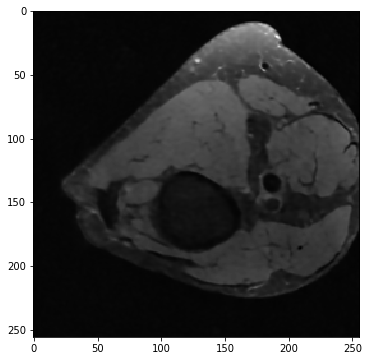

In [18]:
plt.figure(figsize = (6,6))
plt.imshow(out[cur_pic][:,:,0], cmap='gray')

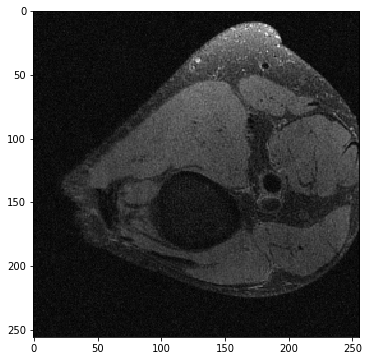

In [19]:
plt.figure(figsize = (6,6))
plt.imshow(Y[cur_pic,:,:,0], cmap='gray' )

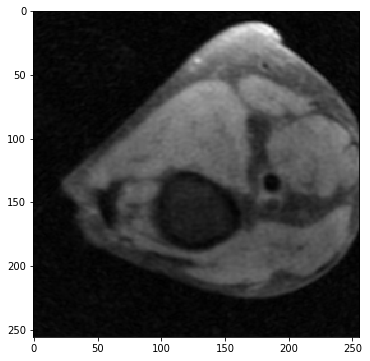

In [20]:
plt.figure(figsize = (6,6))
plt.imshow(X[cur_pic,:,:,0], cmap='gray' )